# Hacking your own tools with Pylinac

Pylinac's main purpose is to make doing routine quality assurance easier and as automatic as possible. The main modules can be utilized in only a few lines of code and does a complete analysis of your QA images. However, when researching new tools, comparing specific algorithms, or doing custom testing, the default tools aren't appropriate. Pylinac's modules are built on simpler tools that can be used directly or easily extended. In this tutorial, we'll introduce some of pylinac's potential as a toolkit for customizing or creating new tests. 

## The ``image`` Module 

In many applications of QA, the physicist has images acquired via the EPID, kV imager, or scanned films. The ``image`` module provides easy tools for loading, manipulating, and converting these images. For this tutorial we'll use a few demo images and showcase the various methods available. 

There are a few simple tips for using the ``image`` module:

  * The ``Image`` class is a swiss-army knife for loading images
  * There are 3 related image classes to handle the given image types: Dicom, File, and Array
  
The docs for the image API are [here](http://pylinac.readthedocs.org/en/latest/core_modules.html#module-pylinac.core.image).

First, our imports for the whole tutorial:

In [1]:
%matplotlib inline

from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import numpy as np

from pylinac.core.image import Image, DicomImage, FileImage, ArrayImage

# pylinac demo images' URL
PF_URL = 'https://github.com/jrkerns/pylinac/blob/master/pylinac/demo_files/picket_fence/EPID-PF-LR.dcm?raw=true'
STAR_URL = 'https://github.com/jrkerns/pylinac/blob/master/pylinac/demo_files/starshot/starshot.tif?raw=true'

# local downloaded images
PF_FILE, _ = urlretrieve(PF_URL)
STAR_FILE, _ = urlretrieve(STAR_URL)

# sample numpy array
ARR = np.arange(36).reshape((6,6))

### Loading images

Let's load the picket fence demo image:

In [2]:
pfimg = Image.load_url(PF_URL)
type(pfimg)

pylinac.core.image.DicomImage

We can load the local file just as easily:

In [3]:
pfimg = Image.load(PF_FILE)

The ``load()`` and ``load_url()`` methods do not return an ``Image`` instance, but rather infers the type of image and returns one of the related Image types listed above.

In [4]:
type(pfimg)

pylinac.core.image.DicomImage

The ``load()`` method can take an string pointing to a file, a data stream, or a numpy array:

In [5]:
arr = np.arange(36).reshape((6,6))
img2 = Image.load(arr)  # .pixel_array is a numpy array of DICOM file
type(img2)

pylinac.core.image.ArrayImage

Additionally, multiple images can be loaded and superimposed. For example multiple collimator star shots. Just pass a list of the images:

In [6]:
star1, _ = urlretrieve('https://github.com/jrkerns/pylinac/blob/master/tests/test_files/Starshot/set/0%20deg%20coll.dcm?raw=true')
star2, _ = urlretrieve('https://github.com/jrkerns/pylinac/blob/master/tests/test_files/Starshot/set/120%20deg%20coll.dcm?raw=true')

superimposed_img = Image.load_multiples([star1, star2])

While the ``load()`` method will always do smart image inference for you, if you already know the file type you can instantiate directly. Furthermore, 2 keyword arguments can be passed to FileImage and ArrayImage if they are known: the DPI (dots-per-inch) and SID (source-to-image distance).

In [7]:
dcm_img = DicomImage(PF_FILE)
arr_img = ArrayImage(ARR, dpi=30, sid=500)
file_img = FileImage(STAR_FILE, dpi=50, sid=1000)

file_img2 = Image.load(STAR_FILE, dpi=30, sid=500)

type(file_img) == type(file_img2)

True

For memory's sake we need to clean up a little.

In [8]:
del file_img2, arr_img, superimposed_img, pfimg

### Plotting

Images can be easily plotted using the ``plot()`` method:

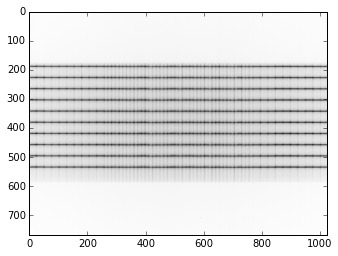

In [9]:
dcm_img.plot()

The plot can also be passed to an existing matplotlib axes:

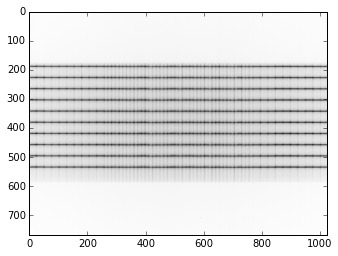

In [10]:
fig, ax = plt.subplots()
dcm_img.plot(ax=ax)

### Attributes

The image classes contain a number of useful attributes for analyzing and describing the data:

In [11]:
dcm_img.dpi

64.79591836734693

In [12]:
dcm_img.dpmm

2.5510204081632653

In [13]:
dcm_img.sid

1000.0

In [14]:
dcm_img.shape

(768, 1024)

There are also attributes that are useful in radiation therapy:

In [15]:
dcm_img.cax  # the beam CAX

Point(x=512.00, y=384.00, z=0.00)

In [16]:
dcm_img.center  # the center location of the image

Point(x=512.00, y=384.00, z=0.00)

Above, the values are the same because the EPID was not translated, which would move the CAX but not the image center.

The image values can also be sampled by slicing and indexing:

In [17]:
dcm_img[12, 60]

2124

In [18]:
dcm_img[:100, 82]

array([1898, 1997, 1912, 2123, 1976, 2044, 2014, 1975, 1946, 1930, 1939,
       2006, 2091, 1979, 2136, 2028, 1996, 2044, 2047, 2195, 2026, 2198,
       2018, 2241, 2050, 2127, 2152, 2076, 2037, 2173, 2058, 2055, 2058,
       2079, 2201, 2278, 2227, 2273, 2155, 2173, 2225, 2123, 2253, 2148,
       2196, 2168, 2129, 2267, 2226, 2306, 2313, 2198, 2254, 2228, 2277,
       2312, 2270, 2213, 2303, 2372, 2365, 2307, 2320, 2317, 2405, 2341,
       2435, 2390, 2334, 2411, 2339, 2332, 2405, 2467, 2362, 2445, 2423,
       2371, 2414, 2370, 2449, 2373, 2493, 2477, 2548, 2525, 2468, 2462,
       2552, 2516, 2603, 2550, 2529, 2557, 2468, 2586, 2535, 2582, 2559,
       2635], dtype=uint16)

In [19]:
del dcm_img

### Data manipulation

Now the really fun stuff! 
There are many methods available to manipulate the data.

First, let's smooth the data:

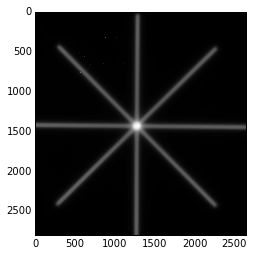

In [20]:
file_img.median_filter(size=3)
file_img.plot()

Sometimes starshots from scanned film have edges that are very high or low value (corners of the film can be bent or rounded). We can easily trim the edges:

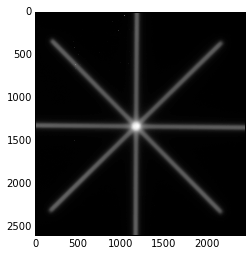

In [21]:
file_img.remove_edges(pixels=100)
file_img.plot()

The data can also be explicitly inverted (EPID images oftentimes need this), or rolled on an axis:

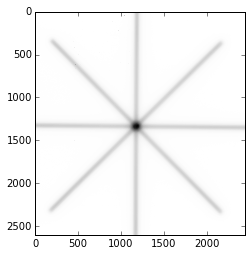

In [22]:
file_img.invert()
file_img.plot()

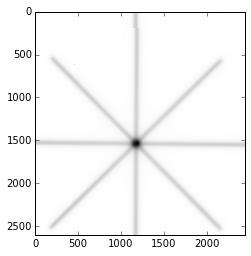

In [23]:
file_img.roll(direction='y', amount=200)
file_img.plot()

We can also rotate and resize the image:

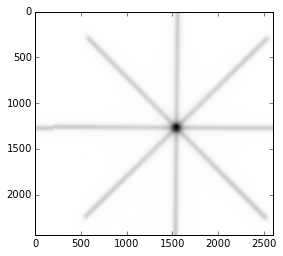

In [24]:
file_img.rot90(n=1)
file_img.plot()

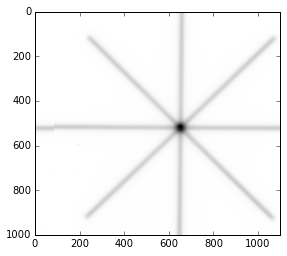

In [25]:
file_img.resize(size=(1000, 1100))
file_img.plot()

Scanned film values can be very high, even in low dose areas. We can thus "ground" the image so that the lowest value is zero; this will help us later on when detecting profiles.

In [26]:
np.min(file_img)

77.999969

In [27]:
file_img.ground()
np.min(file_img)

0.0

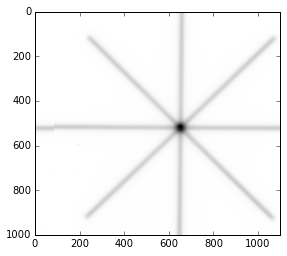

In [28]:
file_img.plot()

We can also apply a high-pass filter to the image:

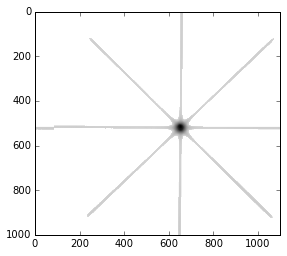

In [29]:
thresh_val = np.percentile(file_img, 95)
file_img.threshold(thresh_val)
file_img.plot()

The image can also be converted to binary, which can be used later for ROI detection. Note that unlike any other method, this returns a new ArrayImage (hinted by the ``as_``)...

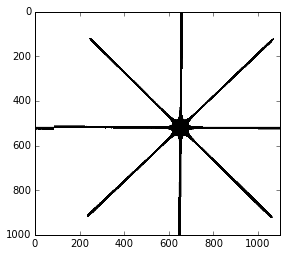

In [30]:
new_img = file_img.as_binary(thresh_val)
new_img.plot()

...and leaves the original unchanged.

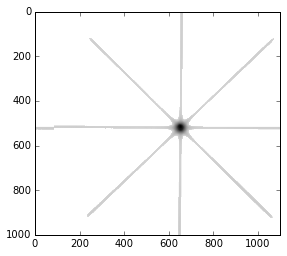

In [31]:
file_img.plot()

## The ``profile`` Module

Physicists often need to evalute a profile, perhaps from a linac beam EPID image, or some fluence profile. The ``profile`` module allows the physicist to find peaks in a 1D array and determine beam profile information (FWHM, penumbra, etc). There are two main profile classes:

* SingleProfile - This class is for profiles with a single peak; e.g. an open beam delivered to a film or EPID. The main goal of this class is to describe the profile (FWHM, penumbra, etc). 
* MultiProfile - This class is for profiles with multiple peaks. The main goal of this class is to find the peak or valley locations. A MultiProfile can be broken down into SingleProfiles.
* CircleProfile - A MultiProfile, but in the shape of a circle. 
* CollapsedCircleProfile - A CircleProfile that "collapses" a thick ring of pixel data to create a 1D profile.

The profile API docs are [here](http://pylinac.readthedocs.org/en/latest/core_modules.html#module-pylinac.core.profile).

For this demonstration we'll find some peaks and then determine profile information about one of those peaks. Let's use the starshot demo image since it contains all the types of profiles:

In [32]:
from pylinac.core.profile import SingleProfile, MultiProfile, CircleProfile, CollapsedCircleProfile

STAR_URL = 'https://github.com/jrkerns/pylinac/blob/master/pylinac/demo_files/starshot/starshot.tif?raw=true'

star_img = Image.load_url(STAR_URL)

### Using a ``MultiProfile``

Let's start by sampling one row from the starshot image:

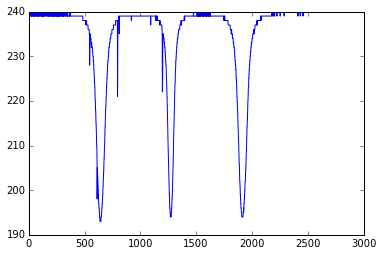

In [33]:
row = star_img[800, :]
plt.plot(row)

So, judging by the profile, it needs to be filtered for the spurious signals, it has multiple peaks, and it's upside down.

Let's make a MultiProfile and clean up the data.

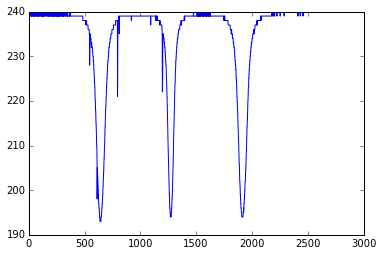

In [34]:
mprof = MultiProfile(row)
mprof.plot()

First, let's invert it so that pixel value increases with dose.

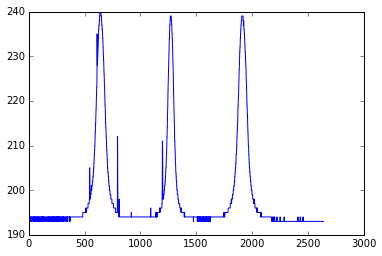

In [35]:
mprof.invert()
mprof.plot()

We've loaded the profile and inverted it; let's run a filter over it.

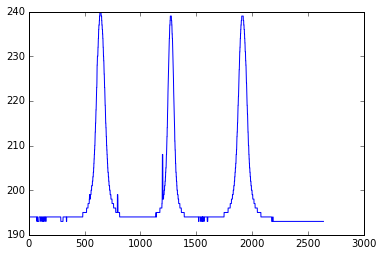

In [36]:
mprof.filter(size=6)
mprof.plot()

The profile could probably be filtered more since there's still a few spurious signals, but this will work nicely for our demonstration.

First, we want to find the peak locations:

In [37]:
mprof.find_peaks()

array([  642.,  1272.,  1914.])

The method has found the 3 major peaks of the profile. Note that there are actually 5 peaks if we count the spurious signals near indices 800 and 1200.

For fun, let's see if we can detect these peaks. We can change the parameters to ``find_peaks()`` to optimize our search. 

In [38]:
mprof.find_peaks(threshold=0.1)

array([  642.,   796.,  1272.,  1914.])

By lowering the peak height threshold we've found another peak; but the peak near 1200 wasn't found. What gives?

The ``find_peaks()`` method also eliminates peaks that are too close to one another. We can change that:

In [39]:
mprof.find_peaks(threshold=0.1, min_distance=0.02)

array([  546.,   642.,   796.,  1199.,  1272.,  1914.])

By changing the minimum distance peaks must be from each other, we've found the other peak. 

But, let's say we need to use these settings for whatever reason. We can additionally limit the number of peaks using ``max_number``.

In [40]:
mprof.find_peaks(threshold=0.1, min_distance=0.02, max_number=3)

array([ 1272.,  1914.,   642.])

Now, we can visualize where these peaks are by using the ``plot()`` method, which shows the peaks if we've searched for them; note the green dots at the detected peak locations.

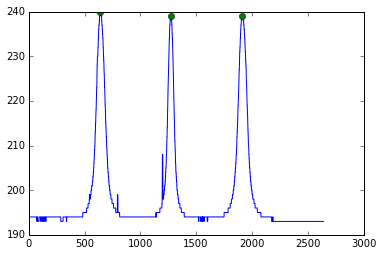

In [41]:
mprof.plot()

We can also search a given portion of the region; for example if we only wanted to detect peaks in the first half of the profile we can easily add a ``search_region``. Note that the last peak was not detected.

In [42]:
mprof.find_peaks(search_region=(0, 0.6))  # search the left 60% of the profile

array([  642.,  1272.])

We can search not simply for the max value peaks, but for the FWHM peaks. Note that these values are slightly different than the max value peaks we found earlier.

In [43]:
mprof.find_fwxm_peaks(x=50)  # 50 is 50% height

[644.0, 1273.0, 1916.5]

Finally, we can subdivide the profile into SingleProfile's to further describe single peaks:

In [44]:
single_profiles = mprof.subdivide()  # returns a list of SingleProfile's

### Using a ``SingleProfile``

``SingleProfile``s are useful to describe profiles with a single peak. It can describe the FWXM (X=any height), penumbra on each side, field width, and calculations of the field. Continuing from above:

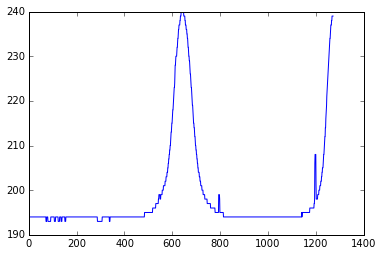

In [45]:
sprof = single_profiles[0]
sprof.plot()

The multiprofile has been cut into multiple single profiles, of which this is the first.

Let's first find the FWHM, and the center of the FWHM:

In [46]:
sprof.fwxm(x=50)

88

In [47]:
sprof.fwxm_center(x=50)

644.0

Note that this is the same value as the first FWHM peak value we found in the MultiProfile.

We can now find the penumbra values:

In [48]:
sprof.penumbra_width(side='left', upper=80, lower=20)

45

In [49]:
sprof.penumbra_width(upper=90, lower=10)  # default is average of both sides

84

The careful reader will notice that the profiles, since we created them, has not had a minimum value of 0. Normally, this would cause problems and sometimes it does, but pylinac normalizes the FWXM and penumbra search. However, just to make sure all is well we can easily shift the values so that the lower bound is 0:

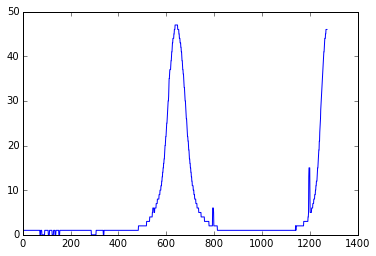

In [50]:
sprof.ground()
sprof.plot()

In [51]:
sprof.penumbra_width(upper=90, lower=10)

84

The average penumbra is the same as we found earlier.

We can also normalize and stretch the profile values. Let's first get the original maximum value so we know what we need to restore the profile:

In [52]:
np.max(sprof)

47.0

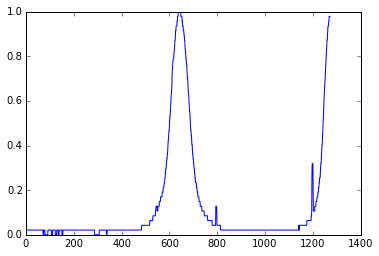

In [53]:
sprof.normalize()
sprof.plot()

We can also stretch the values to be bounded by any values we please:

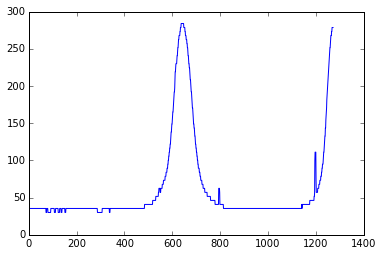

In [54]:
sprof.stretch(min=30, max=284)
sprof.plot()

Let's restore our profile based on the earlier max and min values:

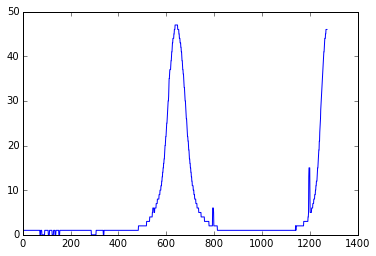

In [55]:
sprof.stretch(max=47, min=0)
sprof.plot()

### Using ``CircleProfile`` and ``CollapsedCircleProfile``

Circular profiles are useful for concentric profiles; starshots are great examples. Let's explore the two circular profiles as they relate to a starshot image. 

Let's once again load the starshot demo image:

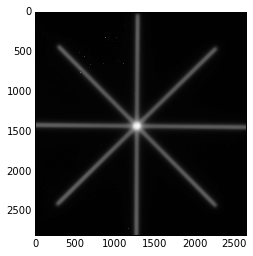

In [56]:
star_img.plot()

We saw above from the profile that the image is actually inverted (pixel value decreases with dose), so we need to invert the image:

In [67]:
star_img.invert()

To use a ``CircleProfile`` we need to specify the center and radius of the circle, as well as the array to operate over. The approximate center of the starshot is (1450, 1250). Let's also use a radius of 300 pixels.

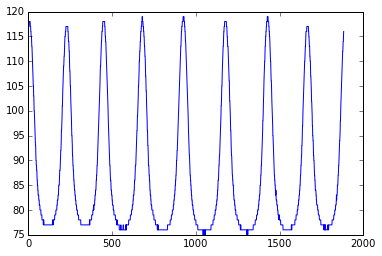

In [68]:
cprof = CircleProfile(center=(1250, 1450), radius=300, image_array=star_img)  #  center is given as (x, y)
cprof.plot()

We have a nice profile showing the starshot peaks. It appears we've cut one of the peaks in half though; this is because the profile starts at 0 radians on the unit circle (directly to the right) and there is a starshot line right at 0. We can also change the direction of the profile from the default of counter-clockwise to clockwise:

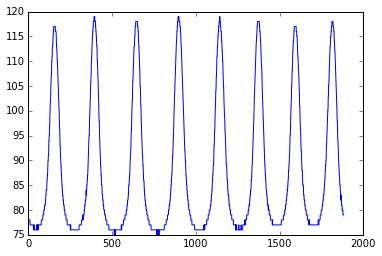

In [69]:
cprof = CircleProfile(center=(1250, 1450), radius=300, image_array=star_img, start_angle=0.2, ccw=False)
cprof.plot()

Alternatively, we can roll the profile directly: 

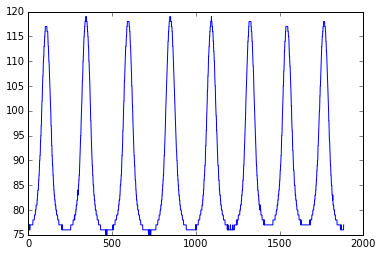

In [70]:
cprof.roll(amount=50)
cprof.plot()

Now, because ``CircleProfile`` is a subclass of ``MultiProfile`` we can search for the peaks:

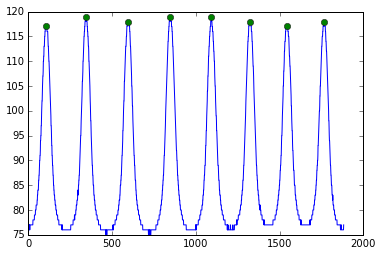

In [71]:
cprof.find_peaks()
cprof.plot()

The profile is 1D, but was derived from a circular sampling. How do we know what the locations of the sampling is? We have x and y attributes:

In [72]:
cprof.x_locations

array([ 1530.05826457,  1529.69820368,  1529.33503504, ...,  1531.11976086,
        1530.7690471 ,  1530.4152137 ])

In [73]:
cprof.y_locations

array([ 1557.55170128,  1558.48462959,  1559.41635252, ...,  1554.74578777,
        1555.68226998,  1556.61757795])

We can also add this profile to a plot to show where it is:

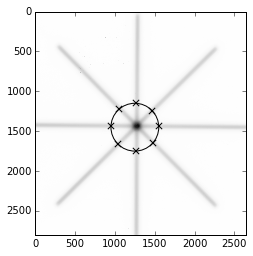

In [74]:
ax = star_img.plot(show=False)
cprof.plot2axes(ax)

Looks good! Now let's take a ``CollapsedCircleProfile``. The advantage of this class is that a thick ring is sampled, which averages the pixel values. Thus, noise and spurious signals are reduced. Beyond ``CircleProfile`` there are 2 more keyword arguments:

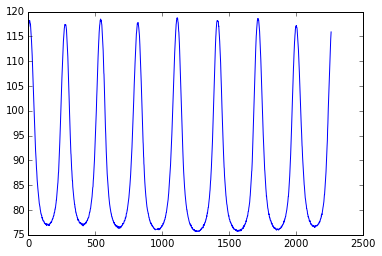

In [75]:
ccprof = CollapsedCircleProfile(center=(1250, 1450), radius=300, image_array=star_img, width_ratio=0.2, num_profiles=10)
ccprof.plot()

Note that this profile looks smoothed; this comes from averaging over the ``num_profiles`` within the ring. The ``width_ratio`` is a function of the radius, so in this case the actual ring width is 300*0.2 = 60 pixels, and 10 equally distributed profiles are taken within that ring.

Let's find the peaks and then plot the ring to the starshot image:

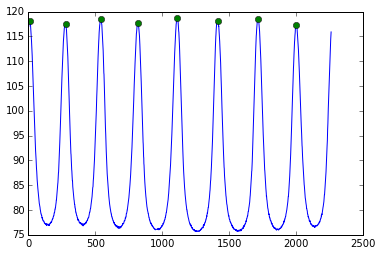

In [76]:
ccprof.find_peaks()
ccprof.plot()

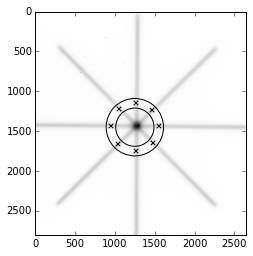

In [77]:
ax = star_img.plot(show=False)
ccprof.plot2axes(ax)

We now have a good start on a starshot algorithm!